In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from methods.model_fitting_utilities import softmax_neg_log_likelihood
from scipy import stats
from scipy.optimize import minimize

In [5]:
summary_ta = pd.read_csv('./data/model_fitting_outputs/summary_data_fit_true.csv')
summary_ta['tag'] = 'TA'
summary_sa = pd.read_csv('./data/model_fitting_outputs/summary_data_run_inters_sparse.csv')
summary_sa['tag'] = 'SA'
summary_ca = pd.read_csv('./data/model_fitting_outputs/summary_data_run_inters.csv')
summary_ca['tag'] = 'CA'
summary_ra = pd.read_csv('./data/model_fitting_outputs/summary_data_run_random.csv')
summary_ra['tag'] = 'RA'
summary = pd.concat([summary_ta, summary_sa, summary_ca, summary_ra], axis=0)
#summary['information_gained'] = (summary['prior_entropy'] - summary['posterior_entropy']) / summary['prior_entropy']

In [6]:
summary.head(4)

,utid,pid,experiment,difficulty,scenario,model_name,ground_truth,posterior_map,posterior_judgement,prior_judgement,prior_entropy,posterior_entropy_unsmoothed,posterior_entropy,model_specs,tag
0,1_56da8da8c5b248000ae2adaf_ccause_generic_0,56da8da8c5b248000ae2adaf,experiment_1,generic_0,ccause,LC_discrete_attention_&_att,[1 1 0 0 0 0],[1. 1. 0. 0. 0. 0.],[0.5 0.5 0. 0. 0. 0. ],NaN,13.931569,9.822617e-17,10.875969,"{'smoothing': 1.72366135, 'decay_rate': 0.0557...",TA
1,1_56da8da8c5b248000ae2adaf_ccause_generic_0,56da8da8c5b248000ae2adaf,experiment_1,generic_0,ccause,LC_discrete_attention_&_att_prior,[1 1 0 0 0 0],[1. 1. 0. 0. 0. 0.],[0.5 0.5 0. 0. 0. 0. ],NaN,13.931569,1.256436e-17,10.161474,"{'smoothing': 1.91400283, 'decay_rate': 0.6367...",TA
2,1_56da8da8c5b248000ae2adaf_ccause_generic_0,56da8da8c5b248000ae2adaf,experiment_1,generic_0,ccause,change_d_obs_fk_&_att_cha,[1 1 0 0 0 0],[ 1. 1. -0.5 0. 0.5 0. ],[0.5 0.5 0. 0. 0. 0. ],NaN,13.931569,2.275894e+00,11.882795,"{'smoothing': 1.6469282, 'decay_rate': 0.56679...",TA
3,1_56da8da8c5b248000ae2adaf_ccause_generic_0,56da8da8c5b248000ae2adaf,experiment_1,generic_0,ccause,change_d_obs_fk_&_att_cha_prior,[1 1 0 0 0 0],[ 1. 1. -0.5 0. 1. 0. ],[0.5 0.5 0. 0. 0. 0. ],NaN,13.931569,2.712320e+00,12.238258,"{'smoothing': 1.55709468, 'decay_rate': 0.6851...",TA


TA, model: LC_discrete_&_1, t=1.81368, p=0.07099
TA, model: normative_&_1, t=1.33788, p=0.18221
SA, model: LC_discrete_&_1, t=1.54956, p=0.12258
SA, model: normative_&_1, t=1.06597, p=0.28752
CA, model: LC_discrete_&_1, t=0.34265, p=0.73216
CA, model: normative_&_1, t=0.62684, p=0.53136
RA, model: LC_discrete_&_1, t=1.61272, p=0.10813
RA, model: normative_&_1, t=1.09028, p=0.27669


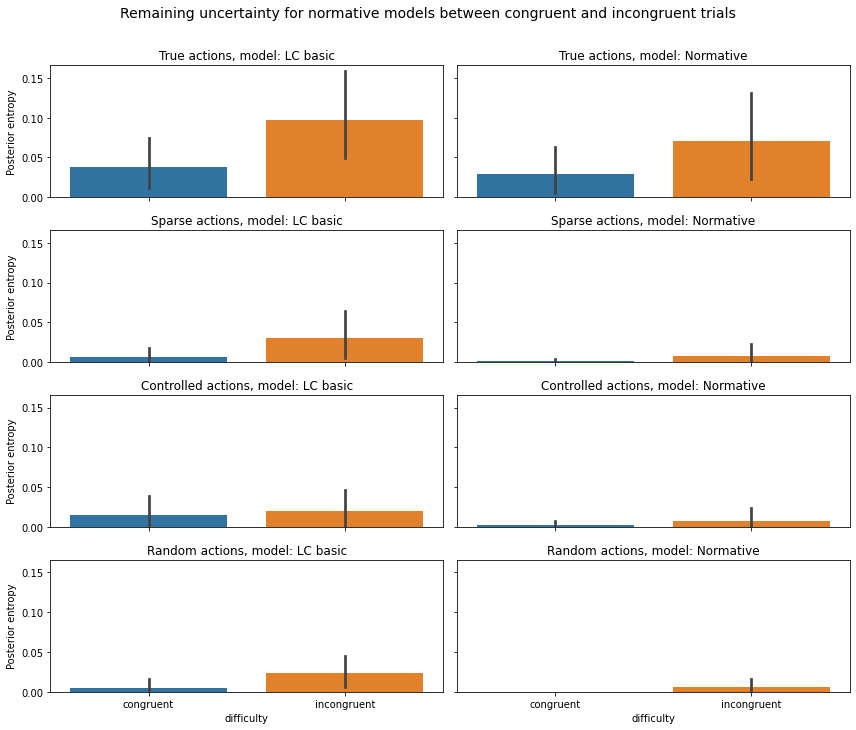

In [16]:
models = ['LC_discrete_&_1', 'normative_&_1']
model_labels = ['LC basic', 'Normative']

tags = ['TA', 'SA', 'CA', 'RA']
tags_label = ['True actions', 'Sparse actions', 'Controlled actions', 'Random actions']

x = 'difficulty'
y = 'posterior_entropy_unsmoothed'
y_label = 'Posterior Entropy'

summary_2 = summary[summary.experiment == 'experiment_3']
fig, axs = plt.subplots(len(tags), len(models), figsize=(12, 10), sharex=True, sharey=True)

for i, tag in enumerate(tags):
    df_tag = summary_2[summary_2.tag == tag]
    
    df_clean = df_tag[df_tag.difficulty.isin(['congruent', 'incongruent', 'implausible'])]

    for j, model in enumerate(models):
        
        df_plot = df_clean[df_clean.model_name == model]
        t, p = stats.ttest_ind(df_plot[df_plot.difficulty == 'incongruent'][y], df_plot[df_plot.difficulty == 'congruent'][y])
        print(f'{tag}, model: {model}, t={np.round(t, 5)}, p={np.round(p, 5)}')
        sns.barplot(x=x, y=y, data=df_plot, ax=axs[i, j])

        if j > 0:
            axs[i, j].set_ylabel('')
        else:
            axs[i, j].set_ylabel('Posterior entropy')

        if i < len(tags) - 1:
            axs[i, j].set_xlabel('')

        axs[i, j].set_title(f'{tags_label[i]}, model: {model_labels[j]}')


fig.suptitle('Remaining uncertainty for normative models between congruent and incongruent trials', fontsize=14, y=1.01)
plt.tight_layout()



In [64]:
models = ['LC_discrete_&_1', 'normative_&_1']

tags = ['TA', 'SA', 'CA', 'RA']

x = 'difficulty'
y = 'posterior_entropy_unsmoothed'
y_label = 'Posterior Entropy'

summary_2 = summary[summary.experiment == 'experiment_3']
fig, axs = plt.subplots(len(tags), len(models), figsize=(20, 10), sharex=True, sharey=True)

for i, tag in enumerate(tags):
    df_tag = summary_2[summary_2.tag == tag]
    
    df_clean = df_tag[df_tag.difficulty.isin(['congruent', 'incongruent', 'implausible'])]

    for j, model in enumerate(models):
        #t, p = stats.ttest_ind()
        df_plot = df_clean[df_clean.model_name == model]
        sns.histplot(df_plot[df_plot.difficulty == 'incongruent'][y], ax=axs[i, j])

        if j > 0:
            axs[i, j].set_ylabel('')
        else:
            axs[i, j].set_ylabel('')

        if i < len(tags) - 1:
            axs[i, j].set_xlabel('')

        axs[i, j].set_title('')

plt.tight_layout()

KeyboardInterrupt: 

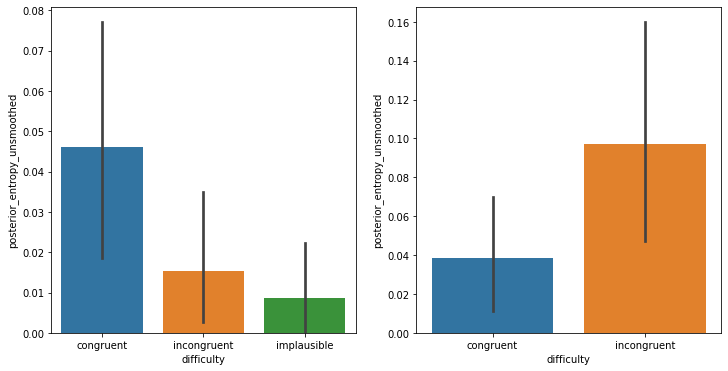

In [33]:
x = 'difficulty'
y = 'posterior_entropy_unsmoothed'

experiments = ['experiment_2', 'experiment_3']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, experiment in enumerate(experiments):
    df_plot = df_norm_label[df_norm_label.experiment == experiment]
    sns.barplot(x=x, y=y, data=df_plot, ax=axs[i])


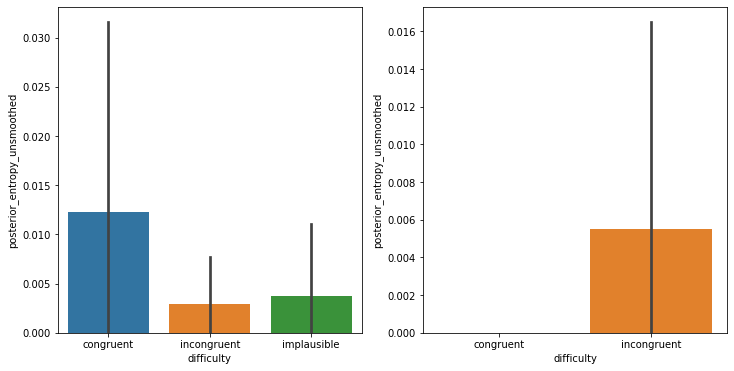

In [36]:
summary = pd.read_csv('./data/model_fitting_outputs/summary_data_run_random.csv')
summary['information_gained'] = (summary['prior_entropy'] - summary['posterior_entropy']) / summary['prior_entropy']

df_norm = summary[summary.model_name == 'normative_&_1']

df_norm_label = df_norm[df_norm.difficulty.isin(['congruent', 'incongruent', 'implausible'])]

x = 'difficulty'
y = 'posterior_entropy_unsmoothed'

experiments = ['experiment_2', 'experiment_3']

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, experiment in enumerate(experiments):
    df_plot = df_norm_label[df_norm_label.experiment == experiment]
    sns.barplot(x=x, y=y, data=df_plot, ax=axs[i])
